In [1]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
# import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"

sc.set_figure_params(figsize=(4, 4))

palette = ['#199de5', '#fbbc04']

In [2]:

sc.set_figure_params(facecolor="white", figsize=(8, 8), dpi_save=300)
sc.settings.verbosity = 1
sc.settings.figdir = './figures-visium/'

In [14]:
path = '/nfs/team292/lg18/gonads/data/visium/'


# sample IDs
donors_match = {
           'Hrv15':["F94", "Hrv15", "Hrv18", 'Hrv32', 'Hrv10', 'F88', 'Hrv27', 'Hrv25'],
           'Hrv69':['Hr69', 'Hrv58', 'Hrv59', 'Hrv65'],
           'F83':["F83", "Hrv34",'Hrv86', 'F133','Hrv59'], 
           'F91':["F91", "F87", 'Hrv37', 'Hrv30','Hrv26'],
           'F94':["F94", "Hrv15", "Hrv18", 'Hrv32', 'Hrv10', 'F88'],
           'Hrv11':["Hrv11", "Hrv85", "Hrv91", "F96", "Hrv39","Hrv57"],
           'F81':['F81', 'Hrv12', 'Hrv47', 'F99', 'F126','F84','Hrv13'],
           'Hrv41':['Hrv41', 'Hrv31'],
           'Hrv58':['Hrv58','Hr69', 'Hrv59', 'Hrv65'],
           'Hrv3':['Hrv3', 'Hrv45', 'Hrv51', 'Hrv19','Hrv71', 'Hrv54'],
           'Hrv27':['Hrv27', 'Hrv25', 'Hrv35', 'F122', 'Hrv40', 'Hrv33'],
           'Hrv13':['Hrv13', 'F99', 'F126','F84']}

Vsamples = {'F91':["FCA_GNDST8796127", "FCA_GNDST8796128"],
           'Hrv11':["FCA_GNDST8796131", "FCA_GNDST8796132"],
           'F83':["FCA_GNDST8796125", "FCA_GNDST8796126"], 
           'F94':["FCA_GNDST8796129", "FCA_GNDST8796130"],
           'F81':['FCA_GNDST9421027'],
           'Hrv41':['FCA_GNDST9421026'],
           'Hrv69':['FCA_GNDST10484130', 'FCA_GNDST10484131'],
           'Hrv58':['FCA_GNDST10484129','FCA_GNDST10484132'],
           'Hrv3':['FCA_GNDST10485488'],
           'Hrv27':['FCA_GNDST10485487'],
           'Hrv13':['FCA_GNDST10485485'],
           'Hrv15':['FCA_GNDST10485486'],
           'females':["FCA_GNDST8796125", "FCA_GNDST8796126", 
                       "FCA_GNDST8796127", "FCA_GNDST8796128", 
                       "FCA_GNDST8796131", "FCA_GNDST8796132",
                      'FCA_GNDST9421027',
                      'FCA_GNDST10484130', 'FCA_GNDST10484131',
                       'FCA_GNDST10484129','FCA_GNDST10484132'],
            'males':["FCA_GNDST8796129", "FCA_GNDST8796130",
                     'FCA_GNDST9421026', 
                     'FCA_GNDST10485488',
                     'FCA_GNDST10485487',
                     'FCA_GNDST10485485',
                     'FCA_GNDST10485486']
           }
            

# Reading Visium data


The function read_visium returns an AnnData object that contains counts, images and spatial coordinates. We will calculate standards QC metrics with pp.calculate_qc_metrics and visualize them.

An anndata will be saved for cell2location.


In [15]:
def read_and_qc(sample_name, path):

    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # mitochondria-encoded (MT) genes should be removed for spatial mapping
    adata.obsm['mt'] = adata[:, adata.var['mt'].values].X.toarray()
    adata = adata[:, ~adata.var['mt'].values]

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'

    return adata


def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

In [16]:
for sam in Vsamples.keys():
    print(sam)
    # read first sample
    adata = read_and_qc(Vsamples[sam][0], path=path)

    # read the remaining samples
    slides = {}
    for i in Vsamples[sam][1:]:
        adata_1 = read_and_qc(i, path=path)
        slides[str(i)] = adata_1

    adata_0 = adata.copy()

    # combine individual samples
    adata = adata.concatenate(
        list(slides.values()),
        batch_key="sample",
        uns_merge="unique",
        batch_categories=Vsamples[sam],
        index_unique=None
    )
    # merging metadata
    adata.obs['sample_name'] = sam

    
    os.system('mkdir -p '+ path+'/cell2location/'+ sam +'/')  
    adata.write(path + '/cell2location/' + sam + '/'+ sam + '_visium.h5ad')
      

F91


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


Hrv11


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


F83


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


F94


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


F81


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


Hrv41


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


Hrv69


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


Hrv58


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


Hrv3


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


Hrv27


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


Hrv13


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


Hrv15


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


females


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call 

males


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call 

In [ ]:
# VsamplesPaper  = {'F91':["FCA_GNDST8796127", "FCA_GNDST8796128"],
#            'Hrv11':["FCA_GNDST8796131", "FCA_GNDST8796132"],
#            'F83':["FCA_GNDST8796125", "FCA_GNDST8796126"], 
#            'F94':["FCA_GNDST8796129", "FCA_GNDST8796130"],
#                    'Hr69':['FCA_GNDST10484130', 'FCA_GNDST10484131'],
#             'Hrv58':['FCA_GNDST10484129','FCA_GNDST10484132'],
#                   'Hrv27':['FCA_GNDST10485487'],
#              'Hrv3':['FCA_GNDST10485488']
#                  }


# fig, axs = plt.subplots(4, 2, figsize=(8, 15))

# j = 0
# for sam in VsamplesPaper.keys():
#     i = 0
#     for sli in Vsamples[sam]:
#         spt_adata =  read_and_qc(Vsamples[sam][0], path=path)
#         sns.distplot(spt_adata.obs["n_genes_by_counts"], kde=False, bins=100, hist_kws={"alpha": 0.2}, ax=axs[j][i])
#         i = i + 1
#     j = j + 1
      

# Reading the merged scRNA dataset


In [5]:
path2sc = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'
adata = sc.read(path2sc+'FCA-gonads_rawcounts.h5ad')
adata.X.shape

(396565, 28820)

In [6]:
# Add old cluster subname
metaF = pd.read_csv(path2sc+'/FCA-gonads_female_annotated.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()

metaM = pd.read_csv(path2sc+'/FCA-gonads_male_annotated.csv')
metaM = metaM.set_index('Unnamed: 0')
metaM.head()


cell_annotM = metaM['lineage'].to_dict()
cell_annotF = metaF['lineage'].to_dict()
cell_annot = {**cell_annotM , **cell_annotF}
adata.obs['lineage'] = adata.obs_names.map(cell_annot).astype('category')

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (29,30,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Add cell type annotations from subanalysis as LABELS

In [7]:
# Add  cluster subname
supF = pd.read_csv(path2sc+'/FCA-gonads_somatic_annotated.csv')
supF = supF.set_index('Unnamed: 0')
supF.head()

supM = pd.read_csv(path2sc+'/FCA-gonads_somaticEarly_annotated.csv')
supM = supM.set_index('Unnamed: 0')
supM.head()

germs = pd.read_csv(path2sc+'/FCA-gonads_germcellsClean_annotated.csv')
germs = germs.set_index('Unnamed: 0')
germs.head()

cell_annotSM = supM['celltype'].to_dict()
cell_annotSF = supF['celltype'].to_dict()
cell_annotG = germs['celltype'].to_dict()
cell_annot = {**cell_annotSM , **cell_annotSF, **cell_annotG}
adata.obs['celltype'] = adata.obs_names.map(cell_annot)#.astype('category')


# Replace NaN with big clusters 
adata.obs['celltype'] = adata.obs['celltype'].fillna(adata.obs['lineage'])
adata.obs['labels'] = adata.obs['celltype']

adata.obs['celltype'].value_counts(dropna = False)

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (29,30,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (29,30,31,32,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Mesenchymal_GATA2       84229
Sertoli                 36917
lowQC                   35077
Ti                      34808
Oi                      25730
preGC_IIb               23825
Epithelial              20222
preGC_I                 15599
Endothelial             14484
preGC_IIa               13772
PV                      12679
OSE                      8222
Doublet                  6091
early_supporting         5894
CoelEpi_LHX9             5547
Immune                   5533
Gi                       4749
cont                     4145
CoelEpi_GATA2            4050
Neural                   3783
PGC                      3764
early_sPAX8              3648
GermCells                3523
SMCs                     3044
FetalLeydig              2874
oogonia_STRA8            2203
late_sPAX8               2118
oogonia_meiotic          1875
CoelEpi_LHX9_cycling     1858
early_somatic            1414
Erythroid                1371
pre_oocyte                812
oocyte                    723
pre_sperma

In [8]:
## Remove unreliable populations
# adata = adata[[ 'G1' in i for i in adata.obs.phase]]
adata = adata[[ 'cycling' not in i for i in adata.obs.labels]]
adata = adata[[ i not in ['GermCells', 'Erythroid', 'cont', 'lowQC', 'Doublet'] for i in adata.obs.labels]]
set(adata.obs.labels)
adata.obs.labels.value_counts()

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Mesenchymal_GATA2    84229
Sertoli              36917
Ti                   34808
Oi                   25730
preGC_IIb            23825
Epithelial           20222
preGC_I              15599
Endothelial          14484
preGC_IIa            13772
PV                   12679
OSE                   8222
early_supporting      5894
CoelEpi_LHX9          5547
Immune                5533
Gi                    4749
CoelEpi_GATA2         4050
Neural                3783
PGC                   3764
early_sPAX8           3648
SMCs                  3044
FetalLeydig           2874
oogonia_STRA8         2203
late_sPAX8            2118
oogonia_meiotic       1875
early_somatic         1414
pre_oocyte             812
oocyte                 723
pre_spermatogonia      621
GC_mitotic             510
GC                     485
granulosa              366
Name: labels, dtype: int64

### Use Ensembl id as GENE 

In [9]:
adata.var['SYMBOL'] = adata.var_names
adata.var.rename(columns={'gene_ids-0': 'ENSEMBL'}, inplace=True)
adata.var_names = adata.var['ENSEMBL']
adata.var.drop(columns='ENSEMBL', inplace=True)

Trying to set attribute `.var` of view, copying.


### Slice dataset per individual

Hrv15


/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variab

labels
CoelEpi_LHX9           534
Endothelial           3044
Epithelial             294
FetalLeydig            753
Immune                 868
Mesenchymal_GATA2    15147
Neural                  56
PGC                    114
PV                    1137
Sertoli              12982
Ti                   13314
late_sPAX8            1644
pre_spermatogonia        4
dtype: int64
Hrv69


/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variab

labels
CoelEpi_LHX9           21
Endothelial          1692
Epithelial           4096
GC_mitotic             32
Gi                     26
Immune                570
Mesenchymal_GATA2    8791
Neural                415
OSE                   104
Oi                   2595
PGC                    49
PV                   4479
SMCs                 3031
granulosa             339
oocyte                225
oogonia_STRA8         145
oogonia_meiotic       235
preGC_I               166
preGC_IIa             116
preGC_IIb             822
pre_oocyte            170
dtype: int64
F83


/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variab

labels
CoelEpi_LHX9           202
Endothelial           1932
GC                     217
GC_mitotic             304
Gi                     280
Immune                 401
Mesenchymal_GATA2     6301
Neural                  82
OSE                   3820
Oi                    9809
PGC                   1311
PV                    1322
early_sPAX8             35
granulosa               26
oocyte                 525
oogonia_STRA8         1489
oogonia_meiotic       1506
preGC_I               2286
preGC_IIa             2639
preGC_IIb            12416
pre_oocyte             646
dtype: int64
F91


/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variab

labels
CoelEpi_GATA2          96
CoelEpi_LHX9          409
Endothelial           654
Epithelial            711
GC                     20
GC_mitotic             55
Gi                    333
Immune                299
Mesenchymal_GATA2    6470
Neural                 45
OSE                  1826
Oi                   4417
PGC                   250
PV                    386
early_sPAX8           305
early_supporting       29
oogonia_STRA8         257
oogonia_meiotic        49
preGC_I              5558
preGC_IIa            4347
preGC_IIb            5245
pre_oocyte             10
dtype: int64
F94


/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variab

labels
CoelEpi_LHX9           474
Endothelial           1371
Epithelial             292
FetalLeydig            394
Immune                 602
Mesenchymal_GATA2    12443
Neural                  51
PGC                    104
PV                     654
Sertoli              10744
Ti                    5450
late_sPAX8             826
dtype: int64
Hrv11


/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variab

labels
CoelEpi_LHX9          237
Endothelial          1239
Epithelial           2404
GC                     29
GC_mitotic             73
Gi                    110
Immune                217
Mesenchymal_GATA2    4075
Neural                623
OSE                   910
Oi                   2591
PGC                   277
PV                   3070
early_sPAX8            32
oocyte                 13
oogonia_STRA8         222
oogonia_meiotic       163
preGC_I               823
preGC_IIa            1192
preGC_IIb            4238
pre_oocyte             63
dtype: int64
F81


/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variab

labels
CoelEpi_GATA2         171
CoelEpi_LHX9          628
Endothelial           417
Epithelial            632
Gi                    342
Immune                125
Mesenchymal_GATA2    7968
Neural                257
OSE                   943
Oi                   3967
PGC                   187
PV                    239
early_sPAX8           957
early_somatic          38
early_supporting      143
preGC_I              5540
preGC_IIa            4674
dtype: int64
Hrv41


/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variab

labels
CoelEpi_GATA2         510
CoelEpi_LHX9          411
Endothelial           518
Epithelial            860
FetalLeydig           200
Immune                384
Mesenchymal_GATA2    3724
PGC                    12
PV                    118
Sertoli               883
Ti                    605
early_sPAX8           348
late_sPAX8            117
dtype: int64
Hrv58


/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variab

labels
CoelEpi_LHX9           21
Endothelial          1692
Epithelial           4096
GC_mitotic             32
Gi                     26
Immune                570
Mesenchymal_GATA2    8791
Neural                415
OSE                   104
Oi                   2595
PGC                    49
PV                   4479
SMCs                 3031
granulosa             339
oocyte                225
oogonia_STRA8         145
oogonia_meiotic       235
preGC_I               166
preGC_IIa             116
preGC_IIb             822
pre_oocyte            170
dtype: int64
Hrv3


/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variab

labels
CoelEpi_LHX9           93
Endothelial           339
Epithelial            188
FetalLeydig           348
GC                    101
GC_mitotic             10
Immune                358
Mesenchymal_GATA2    1241
PGC                   340
PV                    226
Sertoli              5515
Ti                   3242
late_sPAX8             70
pre_spermatogonia     390
dtype: int64
Hrv27


/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variab

labels
CoelEpi_LHX9           674
Endothelial           2236
Epithelial             308
FetalLeydig            799
GC                      91
GC_mitotic              31
Immune                 850
Mesenchymal_GATA2     9494
Neural                  22
PGC                   1003
PV                     737
Sertoli              13313
Ti                   18125
late_sPAX8             939
pre_spermatogonia      115
dtype: int64
Hrv13


/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variab

labels
CoelEpi_GATA2         118
CoelEpi_LHX9          504
Endothelial           178
Epithelial            484
Gi                    136
Immune                 68
Mesenchymal_GATA2    2723
Neural                 17
OSE                   598
Oi                   1789
PGC                   173
PV                    120
early_sPAX8           663
early_somatic          36
early_supporting      109
preGC_I              2759
preGC_IIa            1797
preGC_IIb              36
dtype: int64


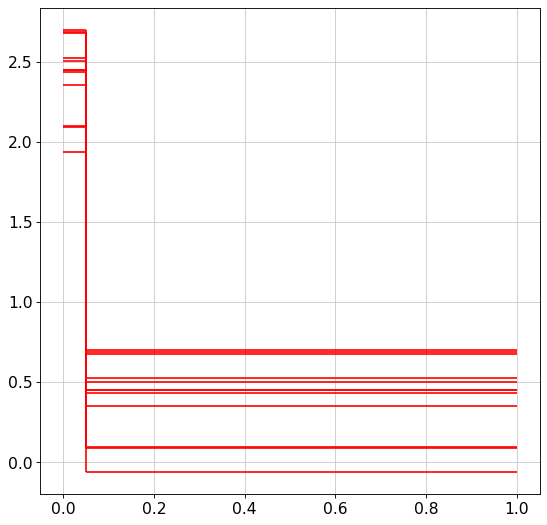

In [13]:
germ_cells = ['PGC', 'PGC_mitotic',  'GC_mitotic',  'oogonia_STRA8',  'oogonia_meiotic', 'pre_oocyte', 'oocyte', 'pre_spermatogonia']
male_cl = ['Ti', 'pre_spermatogonia', 'FetalLeydig', 'Sertoli', 'late_sPAX8']
female_cl = ['Oi',  'oogonia_STRA8',  'oogonia_meiotic', 'pre_oocyte', 'oocyte', 'preGC_I', 'preGC_IIa', 'preGC_IIb',  'granulosa', 'OSE']

for sam in donors_match.keys():
    print(sam)
    andata_f = adata[[ind in donors_match[sam] for ind in adata.obs['donor']]]
    freqs = andata_f.obs.groupby('labels').size()
    # keep labels more than 5 cells
#     if 'Hrv11' in sam:
#         andata_f = andata_f[[i  in freqs[ freqs > 6].index for i in andata_f.obs.labels ]]
#     else:
    andata_f = andata_f[[i in freqs[ freqs > 3 ].index for i in andata_f.obs.labels ]] 
    andata_f = andata_f[[i in freqs[ freqs > 15 ].index or i in germ_cells for i in andata_f.obs.labels ]]        
       
    # F83 does not have any epithelial duct, from visual inspection of the H&E
    if 'F83' in sam:
        andata_f = andata_f[[ i not in 'Epithelial'  for i in andata_f.obs.labels ]] 
        andata_f = andata_f[[ i not in male_cl  for i in andata_f.obs.labels ]]  
    if 'Hrv69' in sam:
        andata_f = andata_f[[ i not in male_cl  for i in andata_f.obs.labels ]] 
    if 'Hrv58' in sam:
        andata_f = andata_f[[ i not in male_cl  for i in andata_f.obs.labels ]] 
    if 'F91' in sam:
        andata_f = andata_f[[ i not in ['granulosa']  for i in andata_f.obs.labels ]]
        andata_f = andata_f[[ i not in male_cl  for i in andata_f.obs.labels ]]  
    if 'Hrv11' in sam:
        andata_f = andata_f[[ i not in ['granulosa']  for i in andata_f.obs.labels ]]
        andata_f = andata_f[[ i not in male_cl  for i in andata_f.obs.labels ]]  
    if 'F81' in sam:
        andata_f = andata_f[[ i not in ['preGC_IIb', 'granulosa']  for i in andata_f.obs.labels ]]
        andata_f = andata_f[[ i not in male_cl  for i in andata_f.obs.labels ]]     
    if 'Hrv13' in sam:
        andata_f = andata_f[[ i not in male_cl  for i in andata_f.obs.labels ]] 
    if 'F94' in sam:
        andata_f = andata_f[[ i not in female_cl  for i in andata_f.obs.labels ]]  
    if 'Hrv41' in sam:
        andata_f = andata_f[[ i not in female_cl  for i in andata_f.obs.labels ]]  
    if 'Hrv3' in sam:
        andata_f = andata_f[[ i not in female_cl  for i in andata_f.obs.labels ]]   
    if 'Hrv15' in sam:
        andata_f = andata_f[[ i not in female_cl  for i in andata_f.obs.labels ]]   
    if 'Hrv27' in sam:
        andata_f = andata_f[[ i not in female_cl  for i in andata_f.obs.labels ]] 
# Reduce the number of genes by discarding lowly expressed genes
# This is performed using 2 cut-off to remove as many lowly expressed genes as possible and yet avoid highly variable gene selection (HVG):
# - Include all genes expressed by at least 1% of cells (cell_count_cutoff2)
# - BECAUSE WE HAVE VERY RARE CELL TYPES (germ cells) Include genes expressed by at least 0.01% of cells (cell_count_cutoff) 
#   when they have high counts in non-zero cells (nonz_mean_cutoff)

    # Remove cells and genes with 0 counts everywhere
    sc.pp.filter_cells(andata_f, min_genes=2)
    sc.pp.filter_genes(andata_f, min_cells=2)

    # calculate the mean of each gene across non-zero cells
    andata_f.var['n_cells'] = (andata_f.X.toarray() > 0).sum(0)
    andata_f.var['nonz_mean'] = andata_f.X.toarray().sum(0) / andata_f.var['n_cells']
    nonz_mean_cutoff = 0.05
    cell_count_cutoff = np.log10(andata_f.shape[0] * 0.0001)
    cell_count_cutoff2 = np.log10(andata_f.shape[0] * 0.01)
    plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2, color='red');
    plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1, color='red');
    plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color='red');

    # select genes based on mean expression in non-zero cells
    andata_ff = andata_f[:,(np.array(np.log10(andata_f.var['nonz_mean']) > nonz_mean_cutoff)
                            | np.array(np.log10(andata_f.var['n_cells']) > cell_count_cutoff2))
                             & np.array(np.log10(andata_f.var['n_cells']) > cell_count_cutoff)
                             & np.array(~andata_f.var.index.isna())]

    os.system('mkdir -p '+ path+'/cell2location/'+sam+'/')  
    andata_ff.write(path + '/cell2location/' + sam + '/'+ sam + '_scRNAseq.h5ad')
    
    freqs = andata_ff.obs.groupby('labels').size()
    print(freqs)

# Slice dataset for females

In [ ]:
germ_cells = ['PGC', 'PGC_mitotic',  'GC', 'GC_mitotic',  'oogonia_STRA8',  'oogonia_meiotic',  'oocyte', 'pre_oocyte']
sam = ['Hrv58', 'Hrv69', 'F83', 'F91', 'Hrv11']
andata_f = adata[[ind in sam for ind in adata.obs['donor']]]
freqs = andata_f.obs.groupby('labels').size()
andata_f = andata_f[[i in freqs[ freqs > 50 ].index for i in andata_f.obs.labels ]] 
andata_f = andata_f[[i in freqs[ freqs > 40 ].index or i in germ_cells for i in andata_f.obs.labels ]]        


# Remove male clusters
andata_f = andata_f[[ i not in male_cl  for i in andata_f.obs.labels ]]  
# Reduce the number of genes by discarding lowly expressed genes
# This is performed using 2 cut-off to remove as many lowly expressed genes as possible and yet avoid highly variable gene selection (HVG):
# - Include all genes expressed by at least 1% of cells (cell_count_cutoff2)
# - BECAUSE WE HAVE VERY RARE CELL TYPES (germ cells) Include genes expressed by at least 0.01% of cells (cell_count_cutoff) 
#   when they have high counts in non-zero cells (nonz_mean_cutoff)

# Remove cells and genes with 0 counts everywhere
sc.pp.filter_cells(andata_f, min_genes=2)
sc.pp.filter_genes(andata_f, min_cells=2)

# calculate the mean of each gene across non-zero cells
andata_f.var['n_cells'] = (andata_f.X.toarray() > 0).sum(0)
andata_f.var['nonz_mean'] = andata_f.X.toarray().sum(0) / andata_f.var['n_cells']
# plt.hist2d(np.log10(andata_f.var['nonz_mean']),
#            np.log10(andata_f.var['n_cells']), bins=100,
#            norm=mpl.colors.LogNorm(),
#            range=[[0,0.5], [1,4.5]]);
nonz_mean_cutoff = 0.05
cell_count_cutoff = np.log10(andata_f.shape[0] * 0.0001)
cell_count_cutoff2 = np.log10(andata_f.shape[0] * 0.01)
plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2, color='red');
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1, color='red');
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color='red');

# select genes based on mean expression in non-zero cells
andata_ff = andata_f[:,(np.array(np.log10(andata_f.var['nonz_mean']) > nonz_mean_cutoff)
                        | np.array(np.log10(andata_f.var['n_cells']) > cell_count_cutoff2))
                         & np.array(np.log10(andata_f.var['n_cells']) > cell_count_cutoff)
                         & np.array(~andata_f.var.index.isna())]

os.system('mkdir -p '+ path+'/cell2location/females/')  
andata_ff.write(path + '/cell2location/females/females_scRNAseq.h5ad')

freqs = andata_ff.obs.groupby('labels').size()
print(freqs)

# Slice dataset for males

In [ ]:
germ_cells = ['sLGR5', 'PGC', 'PGC_mitotic',  'GC_mitotic',  'oogonia_STRA8',  'oogonia_meiotic',  'oocyte', 'gonocyte']
sam = ['F94', 'Hrv41', 'Hrv3', 'Hrv27','Hrv15']
andata_f = adata[[ind in sam for ind in adata.obs['donor']]]
freqs = andata_f.obs.groupby('labels').size()
andata_f = andata_f[[i in freqs[ freqs > 5 ].index for i in andata_f.obs.labels ]] 
andata_f = andata_f[[i in freqs[ freqs > 30 ].index or i in germ_cells for i in andata_f.obs.labels ]]        


# Remove female clusters
andata_f = andata_f[[ i not in female_cl  for i in andata_f.obs.labels ]] # Reduce the number of genes by discarding lowly expressed genes
# This is performed using 2 cut-off to remove as many lowly expressed genes as possible and yet avoid highly variable gene selection (HVG):
# - Include all genes expressed by at least 1% of cells (cell_count_cutoff2)
# - BECAUSE WE HAVE VERY RARE CELL TYPES (germ cells) Include genes expressed by at least 0.01% of cells (cell_count_cutoff) 
#   when they have high counts in non-zero cells (nonz_mean_cutoff)

# Remove cells and genes with 0 counts everywhere
sc.pp.filter_cells(andata_f, min_genes=2)
sc.pp.filter_genes(andata_f, min_cells=2)

# calculate the mean of each gene across non-zero cells
andata_f.var['n_cells'] = (andata_f.X.toarray() > 0).sum(0)
andata_f.var['nonz_mean'] = andata_f.X.toarray().sum(0) / andata_f.var['n_cells']
# plt.hist2d(np.log10(andata_f.var['nonz_mean']),
#            np.log10(andata_f.var['n_cells']), bins=100,
#            norm=mpl.colors.LogNorm(),
#            range=[[0,0.5], [1,4.5]]);
nonz_mean_cutoff = 0.05
cell_count_cutoff = np.log10(andata_f.shape[0] * 0.0001)
cell_count_cutoff2 = np.log10(andata_f.shape[0] * 0.01)
plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2, color='red');
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1, color='red');
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color='red');

# select genes based on mean expression in non-zero cells
andata_ff = andata_f[:,(np.array(np.log10(andata_f.var['nonz_mean']) > nonz_mean_cutoff)
                        | np.array(np.log10(andata_f.var['n_cells']) > cell_count_cutoff2))
                         & np.array(np.log10(andata_f.var['n_cells']) > cell_count_cutoff)
                         & np.array(~andata_f.var.index.isna())]

os.system('mkdir -p '+ path+'/cell2location/males/')  
andata_ff.write(path + '/cell2location/males/males_scRNAseq.h5ad')

freqs = andata_ff.obs.groupby('labels').size()
print(freqs)